In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')
nvmlShutdown()

GPU0 Memory: 11172MB


In [2]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import re
import time
import random

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from make_parallel import make_parallel

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
IMAGE_DIR = 'image_contest_level_2'

DESCRIPTION = 'l2加层生成器2'
MODEL_NAME = 'model_%s_best.h5' % DESCRIPTION

Using TensorFlow backend.


# 载入基本数据

In [3]:
df = pd.read_csv('image_contest_level_2/labels.txt', sep=' ', header=None)
characters = u'0123456789()+-*/=君不见黄河之水天上来奔流到海复回烟锁池塘柳深圳铁板烧; '

labels_len = np.array(map(lambda x:len(x.decode('utf-8')), df[0]))
n_len = 45
n, width, height, n_class, channels = 100000, 900, 72, len(characters), 3

In [4]:
def decode(out):
    return ''.join([characters[x] for x in out if x < n_class-1 and x > -1])

def disp2(img):
    cv2.imwrite('a.png', img)
    return display(Image('a.png'))

def disp(img, txt=None, first=False):
    global index
    if first:
        index = 1
        plt.figure(figsize=(16, 9))
    else:
        index += 1
    plt.subplot(4, 1, index)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if txt:
        plt.title(txt)

# 构建模型

In [5]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

rnn_size = 128

l2_rate = 1e-5

input_tensor = Input((width, height, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 3, 6]):
    for j in range(n_cnn):
        x = Conv2D(32*2**i, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_rate))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

cnn_model = Model(input_tensor, x, name='cnn')

input_tensor = Input((width, height, 3))
x = cnn_model(input_tensor)

conv_shape = x.get_shape().as_list()
rnn_length = conv_shape[1]
rnn_dimen = conv_shape[3]*conv_shape[2]

print conv_shape, rnn_length, rnn_dimen

x = Reshape(target_shape=(rnn_length, rnn_dimen))(x)
rnn_length -= 2

x = Dense(rnn_size, kernel_initializer='he_normal', kernel_regularizer=l2(l2_rate))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

gru_1 = GRU(rnn_size, implementation=2, return_sequences=True, name='gru1')(x)
gru_1b = GRU(rnn_size, implementation=2, return_sequences=True, go_backwards=True, name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, implementation=2, return_sequences=True, name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, implementation=2, return_sequences=True, go_backwards=True, name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
rnn_out = x
base_model = Model(input_tensor, x)

base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model2.output, labels, input_length, label_length])

model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')
model.save('test.h5')

[None, 112, 9, 128] 112 1152


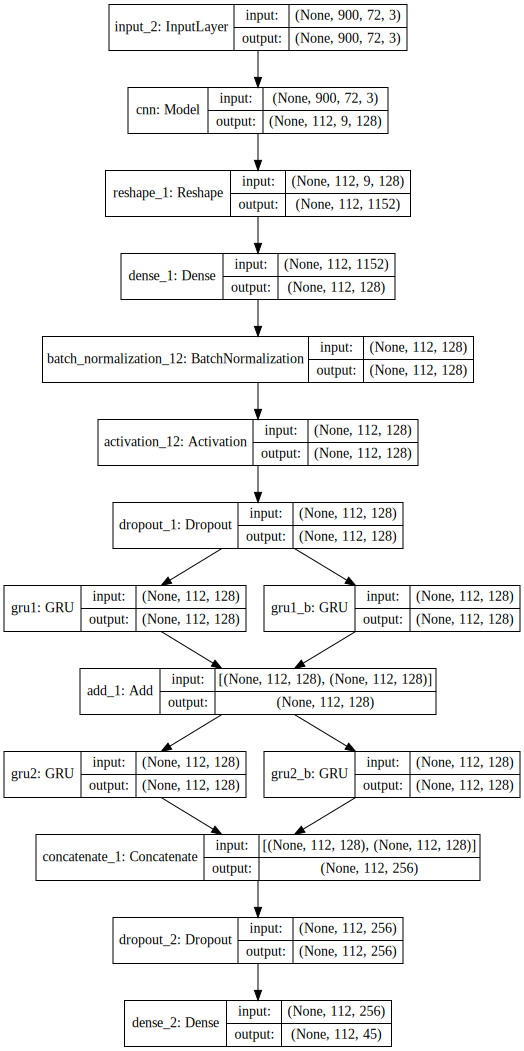

In [6]:
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

# 载入训练集做验证集

In [7]:
n1 = 350*256
n2 = 390*256

X = np.zeros((n2-n1, width, height, channels), dtype=np.uint8)
y = np.zeros((n2-n1, n_len), dtype=np.uint8)

for i in tqdm(range(n1, n2)):
    img = cv2.imread('crop_split/%d.png'%i).transpose(1, 0, 2)
    a, b, _ = img.shape
    X[i-n1, :a, :b] = img
    
    label = df[0][i].decode('utf-8')
    y[i-n1,:len(label)] = [characters.find(x) for x in label]
    y[i-n1,len(label):] = n_class-1

X_val = [X, y, np.ones(n2-n1)*rnn_length, labels_len[n1:n2]]

100%|██████████| 10240/10240 [00:10<00:00, 960.51it/s] 


# 生成器

In [8]:
from collections import defaultdict

cn_imgs = defaultdict(list)
cn_labels = defaultdict(list)
ss_imgs = []
ss_labels = []

for i in tqdm(range(n1)):
    ss = df[0][i].decode('utf-8').split(';')
    m = len(ss)-1
    ss_labels.append(ss[-1])
    ss_imgs.append(cv2.imread('crop_split/%d_%d.png'%(i, 0)).transpose(1, 0, 2))
    for j in range(m):
        cn_labels[ss[j][0]].append(ss[j])
        cn_imgs[ss[j][0]].append(cv2.imread('crop_split/%d_%d.png'%(i, m-j)).transpose(1, 0, 2))

100%|██████████| 89600/89600 [01:54<00:00, 784.04it/s]


In [9]:
from keras.utils import Sequence

class SGen(Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.X_gen = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
        self.y_gen = np.zeros((batch_size, n_len), dtype=np.uint8)
        self.input_length = np.ones(batch_size)*rnn_length
        self.label_length = np.ones(batch_size)*38
    
    def __len__(self):
        return 350*256 // self.batch_size
    
    def __getitem__(self, idx):
        random.seed(time.time()*100000+idx)
        self.X_gen[:] = 0
        for i in range(self.batch_size):
            random_index = random.randint(0, n1-1)
            cls = []
            ss = ss_labels[random_index]
            cs = re.findall(ur'[\u4e00-\u9fff]', df[0][random_index].decode('utf-8').split(';')[-1])
            random.shuffle(cs)
            x = 0
            for c in cs:
                random_index2 = random.randint(0, len(cn_labels[c])-1)
                cls.append(cn_labels[c][random_index2])
                img = cn_imgs[c][random_index2]
                w, h, _ = img.shape
                self.X_gen[i, x:x+w, :h] = img
                x += w+2
            img = ss_imgs[random_index]
            w, h, _ = img.shape
            self.X_gen[i, x:x+w, :h] = img
            cls.append(ss)

            random_str = u';'.join(cls)
            self.y_gen[i,:len(random_str)] = [characters.find(x) for x in random_str]
            self.y_gen[i,len(random_str):] = n_class-1
            self.label_length[i] = len(random_str)
        
        return [self.X_gen, self.y_gen, self.input_length, self.label_length], np.ones(self.batch_size)

### 可视化生成器

110.0
40.0
天=1143;烧=93198;(47070-天/93263)*(烧*93206)


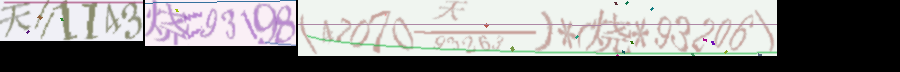

In [10]:
gen = SGen(1)
(X_vis, y_vis, input_length_vis, label_length_vis), _ = gen[0]
print input_length_vis[0]
print label_length_vis[0]
print decode(y_vis[0])
disp2(X_vis[0].transpose((1, 0, 2)))

# 训练

In [18]:
def evaluate():
    global out
    y_pred = base_model2.predict(X, batch_size=256, verbose=1)
    out = K.get_value(K.ctc_decode(y_pred[:,2:], input_length=np.ones(y_pred.shape[0])*rnn_length)[0][0])[:, :n_len]
    out[out == -1] = n_class-1
    score = (out == y[:,:out.shape[-1]]).all(axis=-1).mean()
    base_model.save('model_%s_%.6f.h5' % (DESCRIPTION, score))
    return score

def train(lr=1e-3, epochs=10, batch_size=128, callbacks=None):
    opt = Adam(lr)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
    model.fit_generator(SGen(batch_size), steps_per_epoch=350*256/batch_size, 
                        workers=6, use_multiprocessing=True,
                        validation_data=(X_val, np.ones(n2-n1)), epochs=epochs, callbacks=callbacks)
    print evaluate()

# 采用每次训练最好的模型

http://keras-cn.readthedocs.io/en/latest/other/callbacks/#modelcheckpoint

In [12]:
from keras.callbacks import *

mc = ModelCheckpoint(MODEL_NAME, save_best_only=True)
cl = CSVLogger('model_%s.csv' % DESCRIPTION, append=True)

In [ ]:
train(epochs=20, callbacks=[mc, cl])

In [ ]:
model.load_weights(MODEL_NAME)
evaluate()

In [ ]:
train(1e-4, callbacks=[mc, cl])

In [ ]:
model.load_weights(MODEL_NAME)
evaluate()

In [ ]:
train(1e-5, callbacks=[mc, cl])

In [ ]:
model.load_weights(MODEL_NAME)
evaluate()

In [ ]:
train(1e-4, callbacks=[mc, cl])

In [ ]:
model.load_weights(MODEL_NAME)
evaluate()

In [ ]:
train(1e-5, callbacks=[mc, cl])

In [ ]:
model.load_weights(MODEL_NAME)
evaluate()

In [25]:
base_model.save('model.h5')